# Load raw data and compute metrics and aggregates

- miles bike lane per miles road per census tract
- crosswalks per mile road per census tract
- combine into accessibility index
- 2020 census population percentages
- accessibility index per capita race

In [1]:
import pandas as pd
import geopandas as gpd
tracts = gpd.read_file('Census_2020_Tracts_with_PL_94-171_Redistricting__Data_for_1990-2020.geojson')

In [2]:
tracts.columns

Index(['OBJECTID_1', 'GEOID_20', 'TRACT_20_NAME', 'TRACT_20_LABEL', 'TRACT_20',
       'F1990_PL_data_TOT_POP', 'F1990_PL_data_WHITE_NOT',
       'F1990_PL_data_BLACK_NOT', 'F1990_PL_data_AMI_NOT',
       'F1990_PL_data_ASIAN_NOT',
       ...
       'F2020_PL_data_HU', 'F2020_PL_data_HU_OCC', 'F2020_PL_data_HU_VACANT',
       'F2020_PL_data_GQ_I', 'F2020_PL_data_GQ_N_I', 'AREA_ACRES', 'AREA_SQMI',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object', length=113)

In [6]:
keep_columns = ["TRACT_20", "AREA_SQMI"]
for col in tracts.columns:
    if col.startswith("F2020"):
        keep_columns.append(col)
keep_columns.append('geometry')
tracts = tracts[keep_columns]

## start with street miles

In [7]:
streets = gpd.read_file('Seattle_Streets.geojson')

In [8]:
streets = streets[['UNITIDSORT', 'UNITDESC', 'geometry']]

In [9]:
union = gpd.overlay(streets, tracts, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/1497522123.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 180 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(streets, tracts, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/1497522123.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  union = gpd.overlay(streets, tracts, how="union").explode().reset_index(drop=True)


In [10]:
# we don't want streets over the water
union.dropna(axis=0, subset=["TRACT_20"], inplace=True)

In [11]:
# function to compute line in coords length in miles
from math import radians, cos, sin, asin, sqrt

# Calculates distance between 2 GPS coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3958.8 # Radius in miles
    return c* r

def coord_linestring_miles(linestring):
    numCoords = len(linestring.coords) - 1
    distance = 0
    for i in range(0, numCoords):
        point1 = linestring.coords[i]
        point2 = linestring.coords[i + 1]
        distance += haversine(point1[0], point1[1], point2[0], point2[1])
    if distance:
        return distance
    else:
        return 0
    

In [12]:
union['miles_road'] = union['geometry'].apply(coord_linestring_miles)

In [13]:
tract_road_miles = union.groupby("TRACT_20").sum()['miles_road']

In [14]:
tracts = tracts.set_index("TRACT_20")
tracts['road_miles'] = tract_road_miles
tracts.reset_index(inplace=True)
tracts

,TRACT_20,AREA_SQMI,F2020_PL_data_TOT_POP,F2020_PL_data_POP_ONE,F2020_PL_data_WHITE_ALONE,F2020_PL_data_BLACK_ALONE,F2020_PL_data_AMI_ALONE,F2020_PL_data_ASIAN_ALONE,F2020_PL_data_PI_ALONE,F2020_PL_data_OTHER_ALONE,...,F2020_PL_data_POP_OVER_18,F2020_PL_data_POP_UNDER_18,F2020_PL_data_U_18_POC,F2020_PL_data_HU,F2020_PL_data_HU_OCC,F2020_PL_data_HU_VACANT,F2020_PL_data_GQ_I,F2020_PL_data_GQ_N_I,geometry,road_miles
0,101,0.160162,3759,3326,1541,806,76,563,17,323,...,3139,620,505,2040,1902,138,33,0,"POLYGON ((-122.29654 47.73198, -122.29653 47.7...",2.622470
1,102,0.931941,4321,3888,2550,439,34,700,13,152,...,3723,598,348,2189,2090,99,51,0,"POLYGON ((-122.29640 47.72651, -122.29461 47.7...",8.479546
2,201,0.697538,4416,3925,2473,403,28,770,14,237,...,3749,667,405,2134,2049,85,13,0,"POLYGON ((-122.32358 47.72130, -122.32357 47.7...",7.693064
3,202,0.571423,4099,3524,2480,242,32,635,13,122,...,3326,773,440,1718,1651,67,48,0,"POLYGON ((-122.31005 47.73392, -122.30869 47.7...",12.363678
4,300,0.467540,2820,2530,1753,172,24,460,0,121,...,2279,541,276,1196,1139,57,33,0,"POLYGON ((-122.34521 47.73413, -122.34510 47.7...",10.917438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,12000,0.554843,3560,3150,2689,110,31,208,11,101,...,2761,799,289,1524,1470,54,5,0,"POLYGON ((-122.39146 47.51607, -122.39146 47.5...",12.041209
176,12100,1.204939,2793,2517,2232,24,13,158,4,86,...,2314,479,167,1258,1189,69,0,0,"POLYGON ((-122.40273 47.51934, -122.40241 47.5...",9.414727
177,26400,0.017399,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-122.32871 47.51659, -122.32864 47.5...",0.289453
178,26500,0.167347,89,72,34,6,2,21,2,7,...,71,18,18,41,36,5,0,0,"POLYGON ((-122.34013 47.51728, -122.33991 47.5...",1.040364


## Now bike miles

In [15]:
bikes = gpd.read_file('Existing_Bike_facilities.geojson')

In [16]:
bikes = bikes[["UNITID", "geometry"]]

In [17]:
union = gpd.overlay(bikes, tracts, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/1379058627.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 180 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(bikes, tracts, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/1379058627.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  union = gpd.overlay(bikes, tracts, how="union").explode().reset_index(drop=True)


In [18]:
# we don't want streets over the water
union.dropna(axis=0, subset=["TRACT_20"], inplace=True)

In [19]:
union['bike_miles'] = union['geometry'].apply(coord_linestring_miles)

In [20]:
tract_bike_miles = union.groupby("TRACT_20").sum()['bike_miles']

In [21]:
tracts = tracts.set_index("TRACT_20")
tracts['bike_miles'] = tract_bike_miles
tracts.reset_index(inplace=True)

In [22]:
tracts['miles_bike_per_road'] = tracts['bike_miles']/tracts['road_miles']

In [23]:
tracts = tracts.fillna(0)

## Crosswalks

In [24]:
crosswalks = pd.read_csv('Marked_Crosswalks.csv')

In [25]:
crosswalks.columns

Index(['X', 'Y', 'OBJECTID', 'COMPKEY', 'UNITID', 'UNITDESC', 'CONDITION',
       'CONDITION_ASSESSMENT_DATE', 'OWNERSHIP', 'CURRENT_STATUS',
       'PRIMARYDISTRICTCD', 'SECONDARYDISTRICTCD', 'OVERRIDEYN', 'COMPTYPE',
       'SEGKEY', 'UNITTYPE', 'OLD_ID', 'APPROACH', 'MARKING_TYPE', 'SCHOOL',
       'MIDBLOCK_CROSSWALK', 'INSTALL_DATE', 'COLOR', 'COMMENTS', 'CATEGORY',
       'OWNERSHIP_DATE', 'CURRENT_STATUS_DATE', 'MAINTAINED_BY',
       'MAINTENANCE_AGREEMENT', 'CURBSPACEID', 'MAINT_DISTRICT',
       'OVERRIDECOMMENT', 'SHAPE_LNG', 'SHAPE_LAT', 'CROSSWALK_CONTROL',
       'MATERIAL', 'ONSTREET', 'XSTRLOW', 'MEAS_FROM_LOW', 'DISTTOLOW',
       'STPOINT', 'XSTRHI', 'MEAS_FROM_HI', 'DISTTOHI', 'OFFSET', 'SIDE',
       'MEASUREMENT_ORIGIN', 'ATTACHMENT_1', 'ATTACHMENT_2', 'ATTACHMENT_3',
       'ATTACHMENT_4', 'ATTACHMENT_5', 'ATTACHMENT_6', 'ATTACHMENT_7',
       'ATTACHMENT_8', 'ATTACHMENT_9', 'MAINTENANCE_GROUP', 'NUM_ATTACHMENTS'],
      dtype='object')

In [26]:
crosswalks = crosswalks[["X", "Y"]].astype(float)

In [27]:
crosswalks = gpd.GeoDataFrame(
    crosswalks, geometry=gpd.points_from_xy(crosswalks.X, crosswalks.Y))

In [28]:
union = gpd.overlay(crosswalks, tracts, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/2694179479.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  union = gpd.overlay(crosswalks, tracts, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/2694179479.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 180 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(crosswalks, tracts, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_92892/2694179479.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior an

In [29]:
union.dropna(axis=0, subset=["TRACT_20"], inplace=True)

In [30]:
cross_count = union.groupby("TRACT_20").count()['X']

In [31]:
tracts = tracts.set_index("TRACT_20")
tracts['cross_count'] = cross_count
tracts.reset_index(inplace=True)

In [32]:
tracts.fillna(0, inplace=True)
tracts['crosses_per_road_mile'] = tracts["cross_count"]/tracts["road_miles"]

## Compute some metrics

In [46]:
tracts['normalized_bike_index'] = tracts["miles_bike_per_road"]/max(tracts["miles_bike_per_road"])
tracts['normalized_cross_index'] = tracts["crosses_per_road_mile"]/max(tracts["crosses_per_road_mile"])
tracts['accessibility_index'] = tracts['normalized_bike_index']/2 + tracts['normalized_cross_index']/2

<AxesSubplot:>

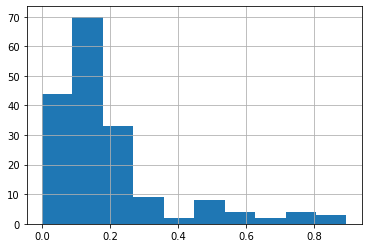

In [47]:
tracts["accessibility_index"].hist()

In [35]:
tracts["POC_ratio"] = tracts["F2020_PL_data_POC"]/tracts["F2020_PL_data_TOT_POP"]

In [37]:
tracts["POC_density"] = tracts["F2020_PL_data_POC"]/tracts["AREA_SQMI"]

In [81]:
import shapely

In [91]:
# reverse order to clockwise
tracts['geometry'] = tracts['geometry'].apply(lambda poly: shapely.geometry.polygon.orient(poly, -1))

In [40]:
import matplotlib.pyplot as plt

<AxesSubplot:>

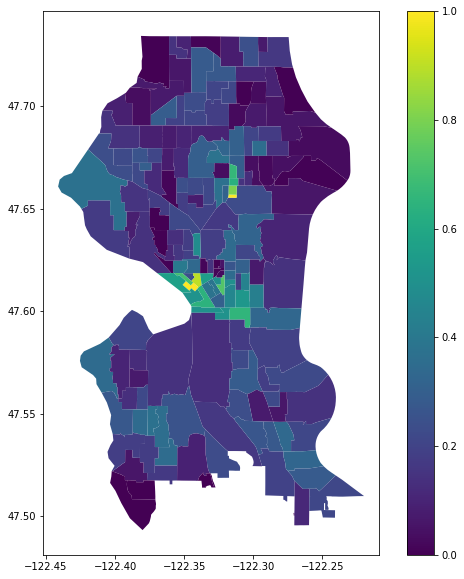

In [94]:
fig, ax = plt.subplots(figsize=(10,10))
tracts.plot(ax=ax, column='normalized_bike_index', legend=True)
# crosswalks.plot(ax=ax)

<AxesSubplot:>

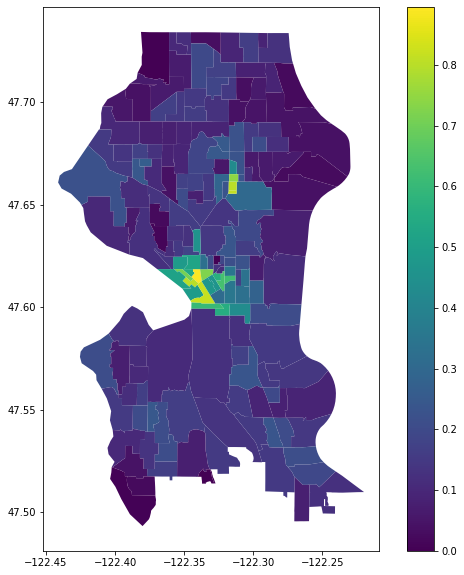

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
tracts.plot(ax=ax, column='accessibility_index', legend=True)
# crosswalks.plot(ax=ax)

Text(0, 0.5, 'accessibility')

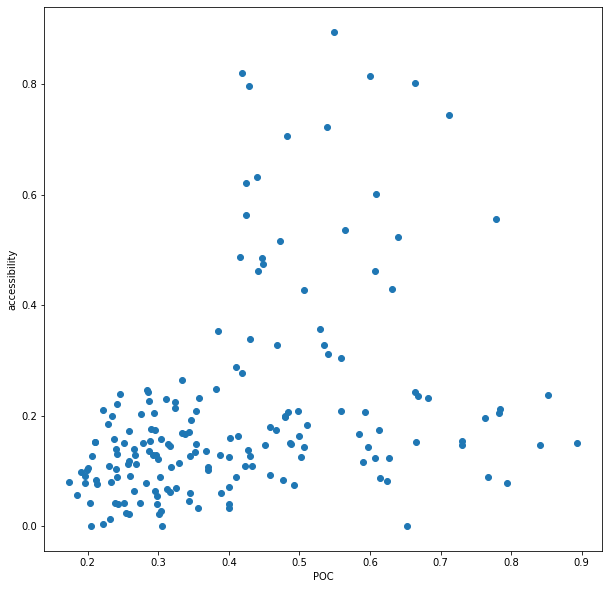

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=tracts['POC_ratio'], y=tracts["accessibility_index"])
ax.set_xlabel("POC")
ax.set_ylabel("accessibility")

In [69]:
import shapely

In [80]:
print(shapely.geometry.polygon.orient(tracts["geometry"][1], -1))

POLYGON ((-122.296404783966 47.7265108455789, -122.294610784419 47.7264958488696, -122.294571784565 47.7264958493073, -122.293570783924 47.7264868510905, -122.29226478478 47.7264758539416, -122.290906784563 47.7264638566216, -122.289558783607 47.7264498595976, -122.289606792767 47.7282788596933, -122.289654800872 47.7300998586463, -122.289704809076 47.7319318582122, -122.289751816265 47.7337338584922, -122.288413816552 47.7337308610941, -122.28704881607 47.7337228638495, -122.286709816944 47.7337258642781, -122.286321816912 47.7337308652036, -122.285955816416 47.7337338664089, -122.284661816852 47.7337388692277, -122.284536816424 47.7337388692267, -122.283756816471 47.7337368710844, -122.282010816921 47.7337388745943, -122.280632816024 47.7337368778206, -122.279631816365 47.7337368800783, -122.274926816808 47.7337338895106, -122.274395816072 47.7337338913287, -122.274366816057 47.7334918909995, -122.273586786733 47.7269298933302, -122.273517785443 47.7266818939128, -122.273489785049 47

In [72]:
-122.296381776429 47.7247038460316
-122.294610784419 47.7264958488696

SyntaxError: invalid syntax (3532017866.py, line 1)

In [54]:
dir(tracts["geometry"][1])

['__and__',
 '__array_interface__',
 '__bool__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__geom__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__p__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_array_interface_base',
 '_crs',
 '_ctypes',
 '_ctypes_data',
 '_empty',
 '_exterior',
 '_geom',
 '_get_coords',
 '_interiors',
 '_is_empty',
 '_lgeos',
 '_ndim',
 '_other_owned',
 '_repr_svg_',
 '_set_coords',
 '_set_geom',
 'almost_equals',
 'area',
 'array_interface_base',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'ctypes',
 'difference',
 'disjoint',
 'distance',

In [78]:
least_accessible = list(tracts["accessibility_index"].sort_values()[:10].index)

In [81]:
most_POC = list(tracts["POC_ratio"].sort_values()[-11:-1].index)

In [82]:
least_accessible

[178, 177, 8, 105, 176, 93, 13, 175, 81, 49]

In [83]:
most_POC

[172, 149, 131, 161, 171, 173, 179, 170, 159, 160]